In [1]:
#Installing all the required Library and Importing it
!pip install transformers
!pip install accelerate==0.20.1
!pip install transformers[torch]
!pip install accelerate -U

!pip install beautifulsoup4
!pip install nlpaug
import nlpaug.augmenter.word as naw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import torch
import re
import seaborn as sns
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer,BertForSequenceClassification
import random
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score, recall_score, precision_score,f1_score
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from google.colab import files
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.20.1
    Uninstalling accelerate-0.20.1:
      Successfully uninstalled accelerate-0.20.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 4.1 MB/s eta 0:00:00


In [2]:
#Here in this code we are setting the seed

seed_value = 42

# Set the random seed for NumPy
np.random.seed(seed_value)

# Set the random seed for Python's built-in random module
random.seed(seed_value)

# Create a random state object for scikit-learn
random_state = check_random_state(seed_value)

In [3]:
# below code we are  is to get google drive authentication
# because we can store the data which need to be trained on drive and call it
# Import PyDrive and associated libraries
# This only needs to be done once per notebook
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
# This only needs to be done once per notebook
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# Download a file based on its file ID.

# The file ID looks like: 1ZpwuB7fCyWaLJv-WKNkn8gYmiVakRlYe
#you can check it by cliking on share option and link will be generated in that link id will be there
file_id = '1ZpwuB7fCyWaLJv-WKNkn8gYmiVakRlYe' # Check your own ID in GDrive
downloaded = drive.CreateFile({'id': file_id})

# Save file in Colab memory
downloaded.GetContentFile('all-data.csv')

In [6]:
#here we are reading the file and re nameing the coloumn
df = pd.read_csv('all-data.csv',header=None, encoding='ISO-8859-1')
df.columns =['Sentiments' ,'Statements']

In [7]:
df.head(10) # printing the sample of the data

,Sentiments,Statements
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
6,positive,"For the last quarter of 2010 , Componenta 's n..."
7,positive,"In the third quarter of 2010 , net sales incre..."
8,positive,Operating profit rose to EUR 13.1 mn from EUR ...
9,positive,"Operating profit totalled EUR 21.1 mn , up fro..."


In [11]:
# in this code we are checking the running  data description
df.shape




(4846, 2)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Sentiments  4846 non-null   object
 1   Statements  4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


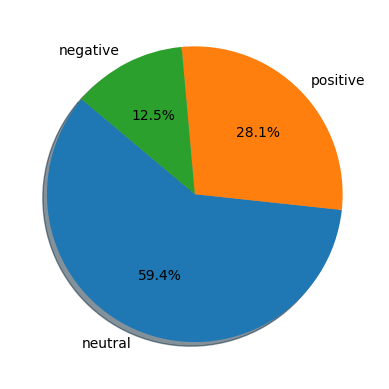

In [13]:
#Checking the data  sentiment distribution through Pie-chart
# we can see the data is highly imbalance
sentiments_count=df["Sentiments"].value_counts()
plt.pie(sentiments_count,labels=sentiments_count.index,
        autopct='%1.1f%%',shadow=True,startangle=140)
plt.show()

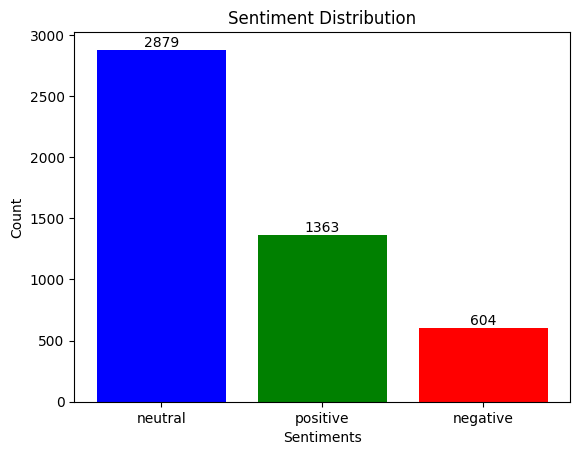

In [14]:
# Calculate the count of each sentiment label
sentiment_counts = df['Sentiments'].value_counts()

# Create a bar chart
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['blue', 'green', 'red'])

# Add labels and title
plt.xlabel('Sentiments')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
for index, value in enumerate(sentiment_counts.values):
    plt.text(index, value, str(value), ha='center', va='bottom')


# Show the plot
plt.show()


In [15]:
# here we are defining a function for giving the numerical value to the sentiment.
#Also applying these value to the data frame on new coloumn
def label_Sentiment_no(st):
    if(st=='positive'):
        return 1 #if +ve return zero
    elif(st=='neutral'):
        return 2
    else:
        return 0 #if negative return 1

df['Sentiment_label'] = df['Sentiments'].apply(label_Sentiment_no)
print(df.head())

  Sentiments                                         Statements  \
0    neutral  According to Gran , the company has no plans t...   
1    neutral  Technopolis plans to develop in stages an area...   
2   negative  The international electronic industry company ...   
3   positive  With the new production plant the company woul...   
4   positive  According to the company 's updated strategy f...   

   Sentiment_label  
0                2  
1                2  
2                0  
3                1  
4                1  


In [16]:
# Below code is used  for balancing the data by RandomOverSampler
import pandas as pd
from imblearn.over_sampling import RandomOverSampler



# Split data into features and labels
X = df["Statements"]
y = df["Sentiment_label"]

# Apply RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X.values.reshape(-1, 1), y)

# Create a new balanced DataFrame
balanced_data = pd.DataFrame({"Statements": X_resampled.flatten(), "Sentiment_label": y_resampled})

# Check the class distribution in the resampled data
class_distribution = balanced_data["Sentiment_label"].value_counts(normalize=True)
print("Balanced Class Distribution:\n", class_distribution)

Balanced Class Distribution:
 2    0.333333
0    0.333333
1    0.333333
Name: Sentiment_label, dtype: float64


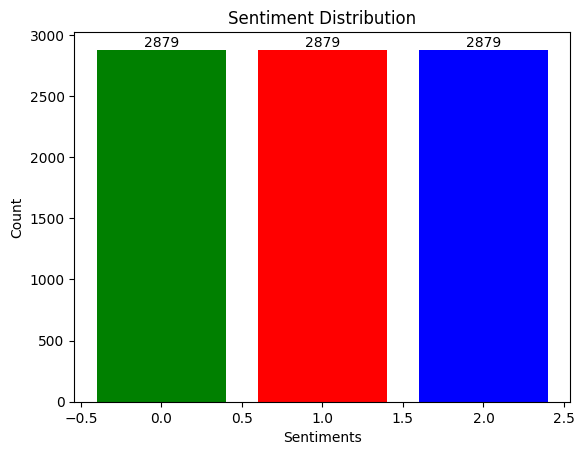

In [17]:
# Calculate the count of each sentiment of balanced data
sentiment_counts = balanced_data['Sentiment_label'].value_counts()

# Create a bar chart
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['blue', 'green', 'red'])

# Add labels and title
plt.xlabel('Sentiments')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
for index, value in enumerate(sentiment_counts.values):
    plt.text(index, value, str(value), ha='center', va='bottom')


# Show the plot
plt.show()

In [19]:
# calling the bert model and its tokenizer
# also loading the bert model to GPU for faster prosessing
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model=model.to('cuda')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
#The below splits data into training and validation sets, tokenizes
#both sets using a BERT tokenizer with specific settings for padding,
#truncation, and sequence length (512), and returns them as PyTorch tensors.

X = list(df["Statements"])
y = list(df["Sentiment_label"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

# Tokenize training data
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512, return_tensors='pt')

# Tokenize validation data
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512, return_tensors='pt')

In [21]:
# Create torch dataset
#This code defines a custom dataset class for efficient handling of tokenized data and optional labels in PyTorch.
#It initializes with encodings (tokenized inputs) and labels, if provided. The getitem method retrieves items by index,
#converting them into PyTorch tensors. The len method returns the dataset's length based on the number of input tokens.
#It's necessary for compatibility with PyTorch's DataLoader and for efficient training and evaluation of machine learning models.

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [22]:
#This code creates two instances of the custom dataset class, 'training_data' and
#'valdtn_data,' using tokenized inputs and
#their corresponding labels for training and validation datasets, respectively.
training_data = Dataset(X_train_tokenized, y_train)
valdtn_data = Dataset(X_val_tokenized, y_val)

In [23]:
#This code defines a function, 'performance_metrics,' that calculates various performance metrics
#like accuracy, recall, precision, and F1 score for a multi-class classification
#task using predicted values ('pred') and actual labels ('labels'). It returns these metrics as a dictionary.
def performance_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [25]:
# Defining Trainer model
#The code configures a machine learning model using Hugging Face Transformers library,
#initializing a 'trainer' object with the model, datasets, and performance metrics
#for sentiment analysis training, ensuring efficient training.
args = TrainingArguments(
    output_dir="output",
    num_train_epochs=3,
    per_device_train_batch_size=10

)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=training_data,
    eval_dataset=valdtn_data,
    compute_metrics=performance_metrics
)

In [26]:
trainer.train() # used for training

<ipython-input-21-c29c31452551>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss
500,0.463700
1000,0.197200


<ipython-input-21-c29c31452551>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-21-c29c31452551>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


TrainOutput(global_step=1164, training_loss=0.3004039882384625, metrics={'train_runtime': 332.504, 'train_samples_per_second': 34.971, 'train_steps_per_second': 3.501, 'total_flos': 896332857814800.0, 'train_loss': 0.3004039882384625, 'epoch': 3.0})

In [28]:
trainer.evaluate() # used for evaluating

<ipython-input-21-c29c31452551>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.6504349708557129,
 'eval_accuracy': 0.8618556701030928,
 'eval_precision': 0.8617265262542958,
 'eval_recall': 0.8618556701030928,
 'eval_f1': 0.8616502017032719,
 'eval_runtime': 6.587,
 'eval_samples_per_second': 147.259,
 'eval_steps_per_second': 18.521,
 'epoch': 3.0}

In [29]:
trainer.save_model('Stock_News_Sentiment_Model') # saving the model

In [30]:
#now loding my own custom model  and will be using it

my_model_bert = BertForSequenceClassification.from_pretrained("Stock_News_Sentiment_Model")
my_model_bert.to('cuda')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [27]:
# Now we will be scraping the data from finviz

In [31]:
# initiallizing the start URL  for finviz and
# difining the top 10 ticker

finviz_url='https://finviz.com/quote.ashx?t='
tickers=['APLE','MSFT','AMZN','TSLA','NVDA','GOOGL','META','ADBE','HON','AAAU']
#APLE= Apple
#MSFT=Microsoft
#AMZN= Amazon
#TSLA=Tesla
#NVDA=Nvidia
#GOOGL=Google/Aplhabet
#META=META
#ADBE=Adobe
#NFLX=Netflix
#HON= Honeywell International
#aaau= goldmansach

In [32]:
#This code scrapes financial news data from the Finviz website for a list of stock tickers.
#It iterates through each ticker, retrieves the HTML content, and parses it to extract news headlines, dates, and times. The extracted data
#is organized into a structured format and stored in 'parsed_data' as a list of lists, making it suitable for further analysis.
news_tables = {}

for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(req)
    html = BeautifulSoup(response, 'html.parser')  # Use 'html.parser' instead of 'html'
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

parsed_data = []

for ticker, news_tables in news_tables.items():
    for row in news_tables.findAll('tr'):
        anchor_tag = row.find('a')  # Find the <a> tag within the <tr>
        if anchor_tag:
            title = anchor_tag.text.strip()
            date_data = row.td.text.strip().replace('\n', '').replace('\r', '').split(" ")

            if len(date_data) == 1:
                time = date_data[0]
            else:
                date = date_data[0]
                time = date_data[1]
            parsed_data.append([ticker, date, time, title])

In [33]:
#checking the  scraped data
data_frame= pd.DataFrame(parsed_data, columns=['ticker','date','time','title'])
print(data_frame.head())
print (" tail")
print(data_frame.tail())

  ticker       date     time  \
0   APLE  Sep-05-23  04:15PM   
1   APLE  Sep-01-23  06:51PM   
2   APLE  Aug-18-23  09:00AM   
3   APLE  Aug-03-23  04:15PM   
4   APLE  Jul-20-23  09:00AM   

                                               title  
0  Apple Hospitality REIT Announces Dates for Thi...  
1  Blackstone and Airbnb Set to Join S&P 500; Oth...  
2  Apple Hospitality REIT Announces Monthly Distr...  
3  Apple Hospitality REIT Reports Results of Oper...  
4  Apple Hospitality REIT Announces Monthly Distr...  
 tail
    ticker       date     time  \
914   AAAU  Sep-11-18  04:39PM   
915   AAAU  Sep-10-18  05:20PM   
916   AAAU  Aug-23-18  03:06PM   
917   AAAU  Aug-15-18  12:44PM   
918   AAAU  Aug-15-18  09:00AM   

                                                 title  
914       A Physical Gold ETF Backed by The Perth Mint  
915     Combating Geopolitical Risks in Your Portfolio  
916                 Investors Get a Shiny New Gold ETF  
917  Exchange Traded Concepts, Perth M

In [38]:
#The below code defines a function called sentiment_label,
#which predicts negative, positive, or neutral sentiment labels for a text review.
#It tokenizes input text, converts it to PyTorch tensors, and uses a BERT model to process outputs.
# The highest probability label is selected as the predicted sentiment, and predicted class indices are mapped to sentiment labels.

predict_score_and_class_dict = {0: 'negative', 1: 'positive',2:'neutral'}
def sentiment_label(review):
    # Tokenize the input text
    inputs = tokenizer(review, return_tensors='pt', padding=True, truncation=True).to('cuda')

    # Get the model outputs (logits)
    outputs = my_model_bert(**inputs).logits

    # Apply softmax to get predicted probabilities
    predictions = torch.nn.functional.softmax(outputs, dim=-1)
    predictions = predictions.cpu().detach().numpy()

    # Get the class label with the highest probability
    predicted_class = np.argmax(predictions)

    # Return the sentiment label
    sentiment = predict_score_and_class_dict[predicted_class]
    return sentiment

# applying the sentiment value
data_frame['sentiment_value'] = data_frame['title'].apply(lambda review: sentiment_label(review))

In [39]:
# removing the null value if any
data_frame.dropna()
data_frame.isnull().any()

ticker             False
date               False
time               False
title              False
sentiment_value    False
dtype: bool

In [40]:
#just cheking the data
data_frame

,ticker,date,time,title,sentiment_value
0,APLE,Sep-05-23,04:15PM,Apple Hospitality REIT Announces Dates for Thi...,neutral
1,APLE,Sep-01-23,06:51PM,Blackstone and Airbnb Set to Join S&P 500; Oth...,neutral
2,APLE,Aug-18-23,09:00AM,Apple Hospitality REIT Announces Monthly Distr...,neutral
3,APLE,Aug-03-23,04:15PM,Apple Hospitality REIT Reports Results of Oper...,neutral
4,APLE,Jul-20-23,09:00AM,Apple Hospitality REIT Announces Monthly Distr...,neutral
...,...,...,...,...,...
914,AAAU,Sep-11-18,04:39PM,A Physical Gold ETF Backed by The Perth Mint,neutral
915,AAAU,Sep-10-18,05:20PM,Combating Geopolitical Risks in Your Portfolio,neutral
916,AAAU,Aug-23-18,03:06PM,Investors Get a Shiny New Gold ETF,neutral
917,AAAU,Aug-15-18,12:44PM,"Exchange Traded Concepts, Perth Mint Launch Ph...",neutral


In [41]:
data_frame['sentiment_value'].value_counts()

neutral     671
positive    127
negative    121
Name: sentiment_value, dtype: int64

In [43]:
# formating the data
from datetime import datetime  # Import the datetime module


# Convert the 'date' column from string to datetime

data_frame = data_frame[data_frame['date'] != 'Today']
data_frame['date'] = pd.to_datetime(data_frame['date'], format='%b-%d-%y')


# Check the data types of columns
print(data_frame.dtypes)

ticker                     object
date               datetime64[ns]
time                       object
title                      object
sentiment_value            object
dtype: object


<ipython-input-43-9d5fdc4bbd74>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['date'] = pd.to_datetime(data_frame['date'], format='%b-%d-%y')


In [44]:
# loading the predicted value in csv file and then uploading to google drive
# which will be used by the tableau  for visualzation
import os
#creating the file name and file path
csv_file = 'StockSentiment.csv'

data_frame.to_csv(csv_file, index=False)
os.rename(csv_file, '/content/' + csv_file)
files.download(csv_file)
# mounting to google drive
from google.colab import drive
drive.mount('/content/drive')

# giving full  file path
file_path = '/content/drive/MyDrive/StockSentiment.csv'

# Check if the file exists
if os.path.exists(file_path):
    os.remove(file_path)
csv_filename = '/content/drive/MyDrive/StockSentiment.csv'
data_frame.to_csv(csv_filename, index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mounted at /content/drive
